In [1]:
import os, sys
LibPath = '../'
if LibPath in sys.path:
    print('YES')
else:
    print('NO, we\'ll add it now')
    sys.path.append(LibPath)
import warnings
warnings.filterwarnings("ignore")

NO, we'll add it now


In [2]:
import numpy as np
import pandas as pd
import networkx as nx
from scipy.cluster.hierarchy import linkage, fcluster, leaders, ClusterNode
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from time import time

from tabulate import tabulate
import matplotlib
import matplotlib.pyplot as plt
# 
from Libraries.Util import Metr, Norm01, seconds_to_str, RemTrend, LowPass, PaintMatr
from Libraries.Util import MovingAverage
from Libraries.graph import AdjMatr, TransMatr
from Libraries.features import CCorrent, CHurst, CEmbDim

In [3]:
def make_gr(traject):
    '''делание графа'''  
    nod=traject['cluster'].values
    G=nx.DiGraph()
    G.add_nodes_from(traject['cluster'].unique())
    r=[(nod[j], nod[j+1]) for j in range(len(traject)-1)]
    c=[r.count(i) for i in r]
    G.add_weighted_edges_from([(nod[j], nod[j+1],c[j]) for j in range(len(traject)-1)])
    return G
def show_gr(G):
    fig=plt.figure(figsize=(7, 7))
    lnd=G.number_of_nodes()+1
    nnd=lnd//7
    nlist=[range(i,i+lnd//nnd) for i in range(0,lnd-lnd//nnd,lnd//nnd)]+[range(lnd-lnd//nnd,lnd)]
    nx.draw(G, pos=nx.shell_layout(G, nlist=nlist),
                   with_labels=True,
                   node_color='pink', font_weight='bold',font_size=10,
                   edge_color='b',node_size=300, width=2 )
    #nx.spectral_layout(G), random, circular
    fig.tight_layout()
    plt.show()
    return 0
def art_ser(l, noise=.3, season=.3):
    x=np.linspace(-40,10,l)
    y=1/(1+np.exp(x))
    x=np.linspace(-10,10,l)
    y+=np.random.random(l)*noise-noise/2
    #x1=x*5+np.random.randn(l)/3
    y+=np.sin(x*3+2*np.sin(x))*season+.25 
    return y

In [4]:
data=pd.read_csv('group_expenses.csv')
data.columns

Index(['date', 'food', 'outfit', 'dwelling', 'health', 'beauty', 'remote',
       'money', 'travel', 'kids', 'nonfood', 'telecom', 'fun', 'charity',
       'misc'],
      dtype='object')

In [5]:
gr='outfit'
ser=MovingAverage(data[gr], numb=len(data)//15)[14:-7]

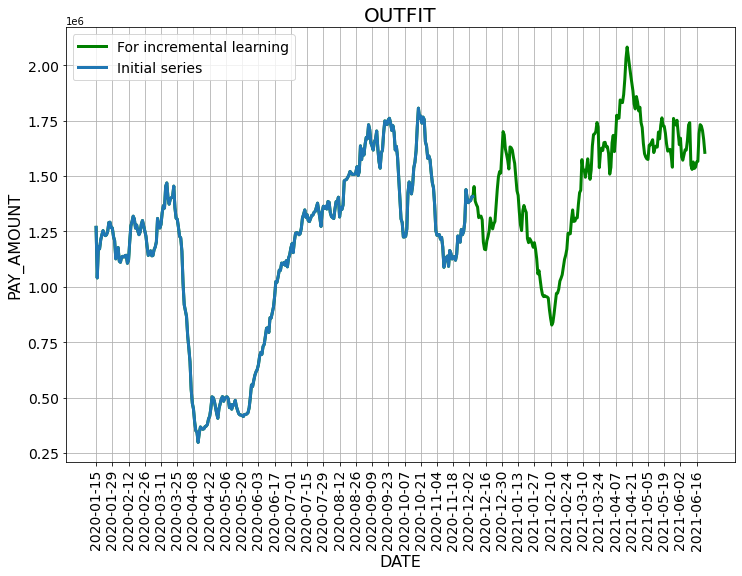

In [6]:
bound=200
row=ser[:-bound]
t=np.arange(len(ser))
plt.figure(figsize=(12,8), facecolor='w') 
plt.title(gr.upper(), size=20)
plt.plot(ser, lw=3, c='g', label='For incremental learning')
plt.plot(row, lw=3, label='Initial series')
# plt.plot(x+data.mean())

# plt.plot(t, a*t+b)
xt=np.arange(14, len(data)-7, 14)
plt.xticks(xt-14, data.date.values[xt], size=14, rotation=90)
plt.yticks(size=14)
plt.xlabel('DATE', size=16)
plt.ylabel('PAY_AMOUNT', size=16)
plt.legend(fontsize=14)
plt.grid(axis='both')
plt.show()

Done!


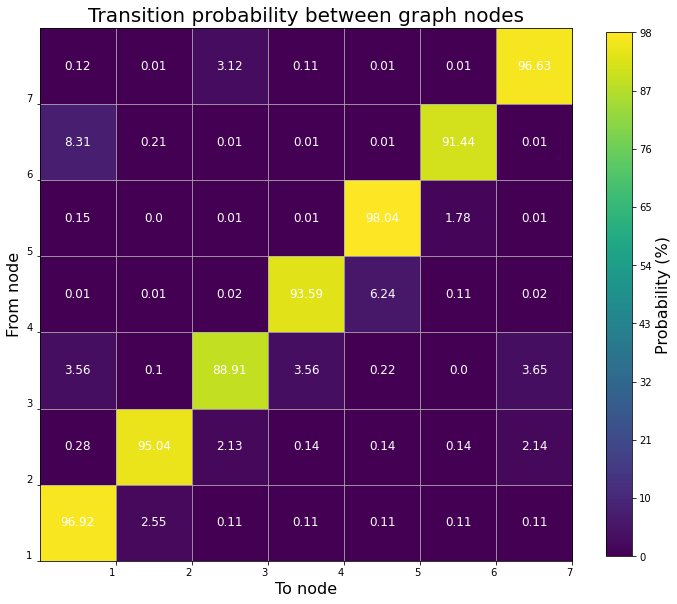

In [7]:
mindist=.05
demb=CEmbDim(row)
depth=demb*2+1
traject=pd.DataFrame(columns=['step']+['t-'+str(j) for j in range(depth-1,-1,-1)])
traject['step']=np.arange(len(row)-depth)
for i in range(len(row)-depth):
    traject.loc[i, traject.columns[1:]]=row[i:i+depth]
'''матрица связей для кластеризации'''
link = linkage(traject[traject.columns[1:]], 'ward', 'euclidean')
'''оптимальное расстояние для кластеризации'''
dist = link[:, 2]
dist_rev = dist[::-1]
i=np.where(np.abs(dist_rev[:-5]-dist_rev[5:])<(max(dist_rev)*mindist))[0][0]
d=dist_rev[i]
'''кластеризация'''
traject['cluster']=fcluster(link, d, criterion='distance')
traject['cluster']=[list(traject['cluster'].drop_duplicates().values).index(i)+1 for i in traject['cluster']]
'''делание графа'''  
G0=make_gr(traject)
print('Done!')
trmat=TransMatr(G0, paint=True)

,step,t-22,t-21,t-20,t-19,t-18,t-17,t-16,t-15,t-14,...,t-9,t-8,t-7,t-6,t-5,t-4,t-3,t-2,t-1,t-0
0,303,1452311.342667,1386219.776,1370877.898667,1359975.722667,1311804.356,1318197.134,1318694.654,1301275.980667,1201533.755333,...,1252404.33,1310386.264,1285134.039333,1260993.876667,1283323.934667,1294589.469333,1369910.050667,1439024.484667,1496124.040667,1519899.486
1,304,1386219.776,1370877.898667,1359975.722667,1311804.356,1318197.134,1318694.654,1301275.980667,1201533.755333,1169394.878,...,1310386.264,1285134.039333,1260993.876667,1283323.934667,1294589.469333,1369910.050667,1439024.484667,1496124.040667,1519899.486,1513149.536667
2,305,1370877.898667,1359975.722667,1311804.356,1318197.134,1318694.654,1301275.980667,1201533.755333,1169394.878,1166982.704667,...,1285134.039333,1260993.876667,1283323.934667,1294589.469333,1369910.050667,1439024.484667,1496124.040667,1519899.486,1513149.536667,1610283.204667
3,306,1359975.722667,1311804.356,1318197.134,1318694.654,1301275.980667,1201533.755333,1169394.878,1166982.704667,1206466.803333,...,1260993.876667,1283323.934667,1294589.469333,1369910.050667,1439024.484667,1496124.040667,1519899.486,1513149.536667,1610283.204667,1700303.98
4,307,1311804.356,1318197.134,1318694.654,1301275.980667,1201533.755333,1169394.878,1166982.704667,1206466.803333,1226307.042,...,1283323.934667,1294589.469333,1369910.050667,1439024.484667,1496124.040667,1519899.486,1513149.536667,1610283.204667,1700303.98,1685807.856
5,308,1318197.134,1318694.654,1301275.980667,1201533.755333,1169394.878,1166982.704667,1206466.803333,1226307.042,1252404.33,...,1294589.469333,1369910.050667,1439024.484667,1496124.040667,1519899.486,1513149.536667,1610283.204667,1700303.98,1685807.856,1621859.455333
6,309,1318694.654,1301275.980667,1201533.755333,1169394.878,1166982.704667,1206466.803333,1226307.042,1252404.33,1310386.264,...,1369910.050667,1439024.484667,1496124.040667,1519899.486,1513149.536667,1610283.204667,1700303.98,1685807.856,1621859.455333,1598012.316667
7,310,1301275.980667,1201533.755333,1169394.878,1166982.704667,1206466.803333,1226307.042,1252404.33,1310386.264,1285134.039333,...,1439024.484667,1496124.040667,1519899.486,1513149.536667,1610283.204667,1700303.98,1685807.856,1621859.455333,1598012.316667,1570668.941333
8,311,1201533.755333,1169394.878,1166982.704667,1206466.803333,1226307.042,1252404.33,1310386.264,1285134.039333,1260993.876667,...,1496124.040667,1519899.486,1513149.536667,1610283.204667,1700303.98,1685807.856,1621859.455333,1598012.316667,1570668.941333,1531312.098667
9,312,1169394.878,1166982.704667,1206466.803333,1226307.042,1252404.33,1310386.264,1285134.039333,1260993.876667,1283323.934667,...,1519899.486,1513149.536667,1610283.204667,1700303.98,1685807.856,1621859.455333,1598012.316667,1570668.941333,1531312.098667,1631132.924


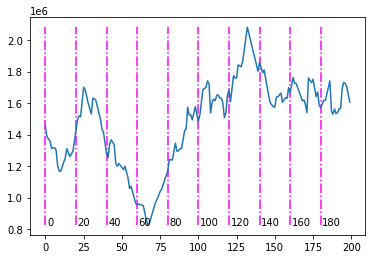

In [8]:
row=ser[-bound:]
plt.figure(facecolor='w')
plt.plot(row)
plt.vlines([k for k in range(0,bound,bound//10)], min(row), max(row), color='magenta', linestyle='-.')
for k in np.arange(0,bound,bound//10):
    plt.text(k+1, min(row)-.1, str(k))
trj=pd.DataFrame(columns=['step']+['t-'+str(j) for j in range(depth-1,-1,-1)])
trj['step']=np.arange(len(row)-depth)+traject['step'].max()+1
for i in range(len(row)-depth):
    trj.loc[i, trj.columns[1:]]=row[i:i+depth]
trj.head(10)

0->New node # 8 appeared!->New node # 9 appeared!->New node # 10 appeared!->New node # 11 appeared!->20->New node # 12 appeared!->New node # 13 appeared!->40->New node # 14 appeared!->New node # 15 appeared!->60->New node # 16 appeared!->New node # 17 appeared!->80->New node # 18 appeared!->100->New node # 19 appeared!->New node # 20 appeared!->New node # 21 appeared!->120->New node # 22 appeared!->New node # 23 appeared!->New node # 24 appeared!->140->160->180->

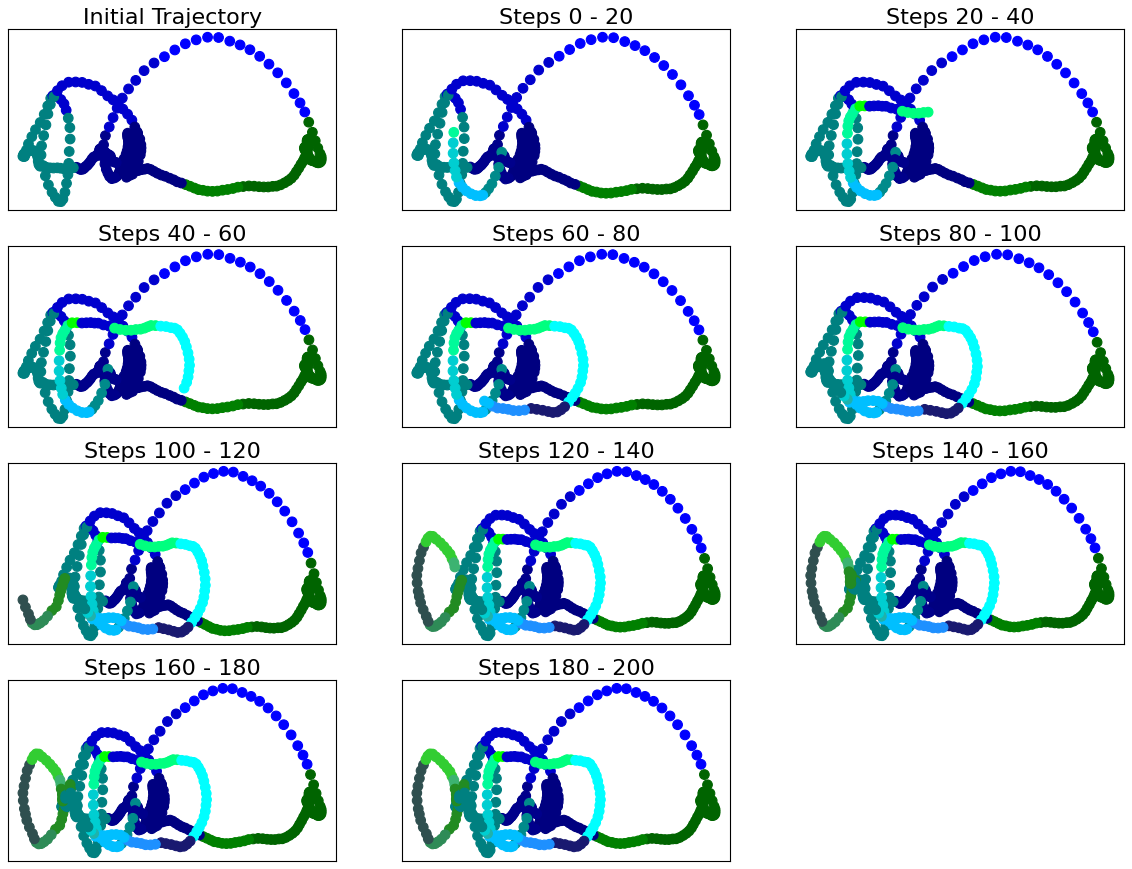


Cluster 1 - 79 points
Cluster 2 - 49 points
Cluster 3 - 35 points
Cluster 4 - 16 points
Cluster 5 - 56 points
Cluster 6 - 12 points
Cluster 7 - 99 points
Cluster 8 - 6 points
Cluster 9 - 15 points
Cluster 10 - 6 points
Cluster 11 - 6 points
Cluster 12 - 2 points
Cluster 13 - 10 points
Cluster 14 - 10 points
Cluster 15 - 9 points
Cluster 16 - 8 points
Cluster 17 - 7 points
Cluster 18 - 1 points
Cluster 19 - 24 points
Cluster 20 - 6 points
Cluster 21 - 6 points
Cluster 22 - 6 points
Cluster 23 - 10 points
Cluster 24 - 2 points


In [10]:
centres={}
colors=list(matplotlib.colors.CSS4_COLORS.values())[::-1]
colors.sort()
d=5e5
gra=[]
gra.append(G0)
for c in traject.cluster.unique():
    centres[c]=traject[traject.cluster==c][traject.columns[1:-1]].values.mean(axis=0)

matplotlib.style.use('classic')
fig=plt.figure(figsize=(18, 13), facecolor='w')
modt = TSNE(learning_rate=150, init='pca', random_state=42)
# Обучаем модель
transformed = modt.fit_transform(traject[traject.columns[1:-1]])
# Представляем результат в двумерны координатах
x0_axis = transformed[:, 0]
y0_axis = transformed[:, 1]
plt.subplot(4,3,1)
plt.title('Initial Trajectory', fontsize=20)
for j in traject.cluster.drop_duplicates():
    plt.scatter(x0_axis[0], y0_axis[0],c=colors[j], s=75)
clss0=[colors[i] for i in traject.cluster.values ]#-cltabula.cluster.values
plt.scatter(x0_axis, y0_axis, color=clss0,  s=75)
plt.xticks(())
plt.yticks(())


n=2
for k in range(0,bound,bound//10):
    print(k, end='->')
    for i in trj.index[k:k+20]:
        step=trj.loc[i, trj.columns[1:]].values
        for j in centres.keys():
            if d >= np.linalg.norm(step-centres[j]):
                newclust=j
                break
        else:
            newclust=traject.cluster.max()+1        
            print('New node # %i appeared!'%newclust, end='->')
        traject=traject.append(trj.loc[i],ignore_index=True)
        traject.loc[traject.step==trj.loc[i].step, 'cluster']=newclust
        centres={}
        for c in traject.cluster.unique():
            centres[c]=traject[traject.cluster==c][traject.columns[1:-1]].values.mean(axis=0)
    traject.cluster=traject.cluster.astype(int)
    #modt = TSNE(learning_rate=150, random_state=42)
    # Обучаем модель
    transformed = modt.fit_transform(traject[traject.columns[1:-1]])
    # Представляем результат в двумерны координатах
    x_axis = transformed[:, 0]
    y_axis = transformed[:, 1]
    plt.subplot(4,3,n)
    plt.title('Steps %i - %i'%(k, k+20), fontsize=20)
    for j in traject.cluster.drop_duplicates():
        plt.scatter(x_axis[0], y_axis[0],c=colors[j], s=75)
    clss=[colors[i] for i in traject.cluster.values ]#-cltabula.cluster.values
    plt.scatter(x_axis, y_axis, color=clss,  s=75)
    plt.xticks(())
    plt.yticks(())
    gra.append(make_gr(traject))
    n+=1
plt.show()
print('')
for c in traject.cluster.unique():
    print('Cluster %i - %i points'%(c, len(traject[traject.cluster==c])))

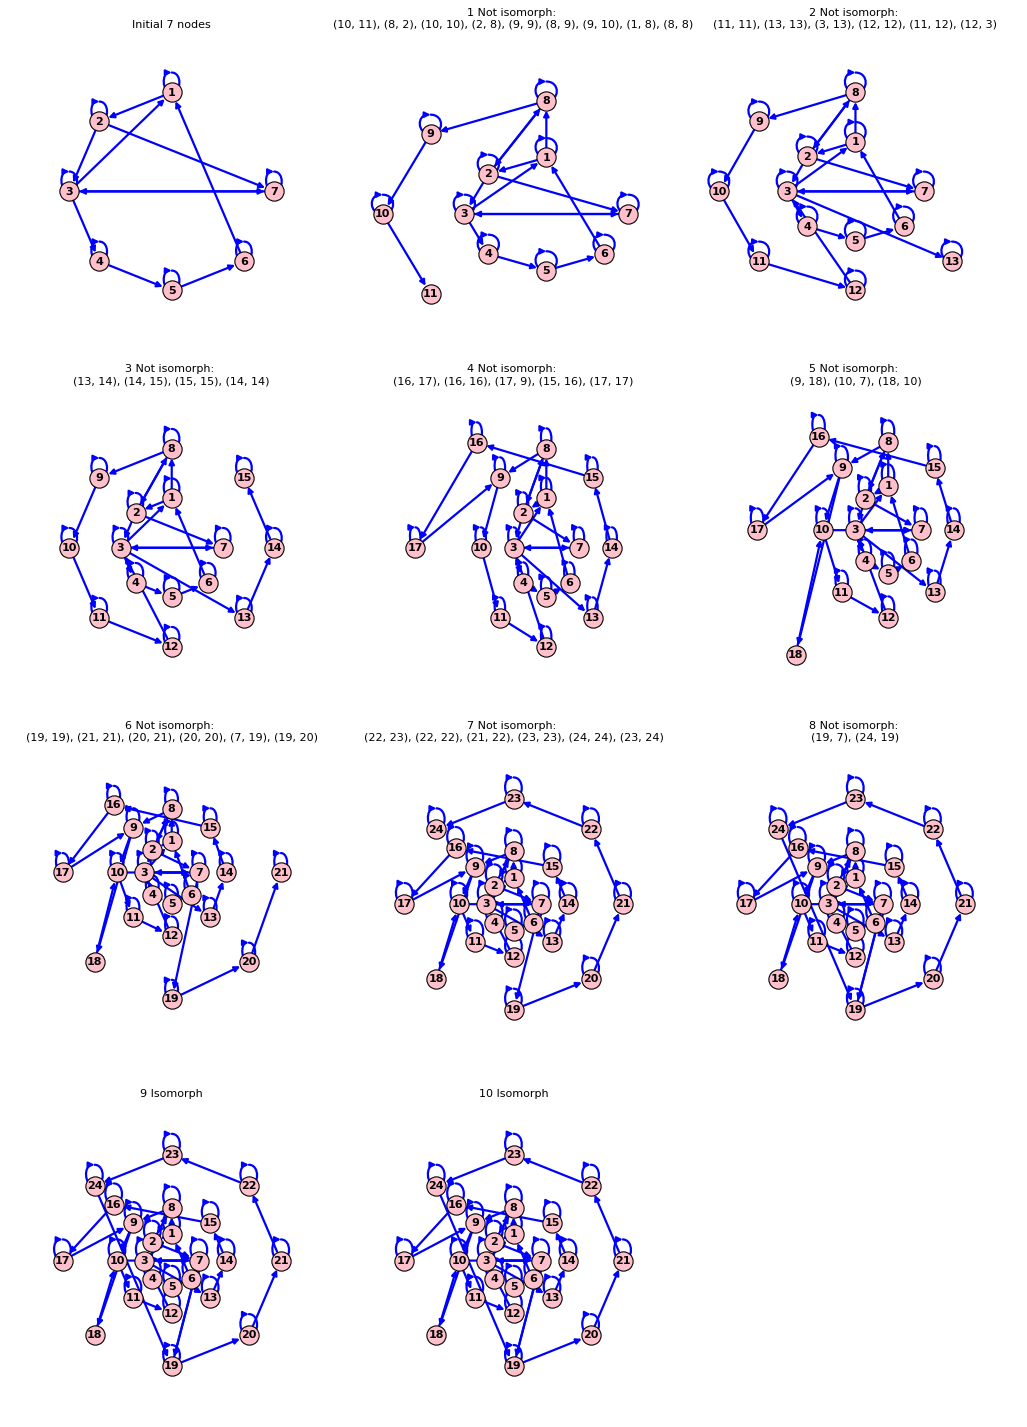

In [11]:
show=True
if show:
    matplotlib.style.use('classic')
    fig=plt.figure(figsize=(13, 18))
    lnd=gra[-1].number_of_nodes()+1
    nnd=lnd//7
    nlist=[range(i,i+lnd//nnd) for i in range(0,lnd-lnd//nnd,lnd//nnd)]+[range(lnd-lnd//nnd,lnd)]
    for i, g in enumerate(gra):
        plt.subplot(4,3,i+1)
        if i:
            e1=set(gra[i-1].edges()) 
            e2=set(g.edges()) 
            plt.title(str(i)+' Isomorph' if nx.is_isomorphic(gra[i-1], g) else str(i)+' Not isomorph: \n'+str(e2.difference(e1))[1:-1], size=10)
        else:
            plt.title('Initial %i nodes'%g.number_of_nodes(), size=10)
        nx.draw(g, pos=nx.shell_layout(g, nlist=nlist),
                   with_labels=True,
                   node_color='pink', font_weight='bold',font_size=10,
                   edge_color='b',node_size=300, width=2 )
    fig.tight_layout()
    
    #plt.savefig('GrowingGraph.png', dpi=600, facecolor='w', edgecolor='w')
    plt.show()
else:
    for i, g in enumerate(gra):
        if i:
            e1=set(gra[i-1].edges()) 
            e2=set(g.edges()) 
            s=('Not isomorph: %i nodes, new edges: '%g.number_of_nodes())
            print(i,'Isomorph' if nx.is_isomorphic(gra[i-1], g) else s+'\n'+str(e2.difference(e1))[1:-1])
        else:
            print(i,('Initial %i nodes'%g.number_of_nodes()) )

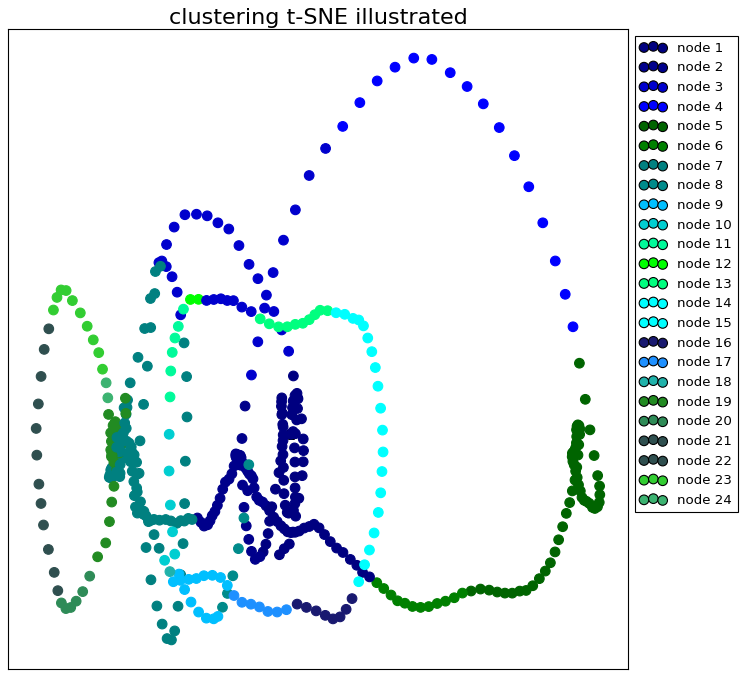

In [12]:
colors=list(matplotlib.colors.CSS4_COLORS.values())[::-1]
colors.sort()
np.random.seed(2)
modt = TSNE(learning_rate=150,  init='pca', random_state=42)
# Обучаем модель
transformed = modt.fit_transform(traject[traject.columns[1:-1]])

# Представляем результат в двумерны координатах
x_axis = transformed[:, 0]
y_axis = transformed[:, 1]
plt.figure(1,figsize=(10,10), facecolor='w')
plt.title('clustering t-SNE illustrated', fontsize=20)
for j in traject.cluster.drop_duplicates():
    plt.scatter(x_axis[0], y_axis[0],c=colors[j], s=75)
clss=[colors[i] for i in traject.cluster.values ]#-cltabula.cluster.values
plt.scatter(x_axis, y_axis, color=clss,  s=75)
plt.xticks(())
plt.yticks(())
plt.legend(['node %i'%i for i in traject.cluster.drop_duplicates()], fontsize=12, loc='best', bbox_to_anchor=(1, 1))
plt.show()

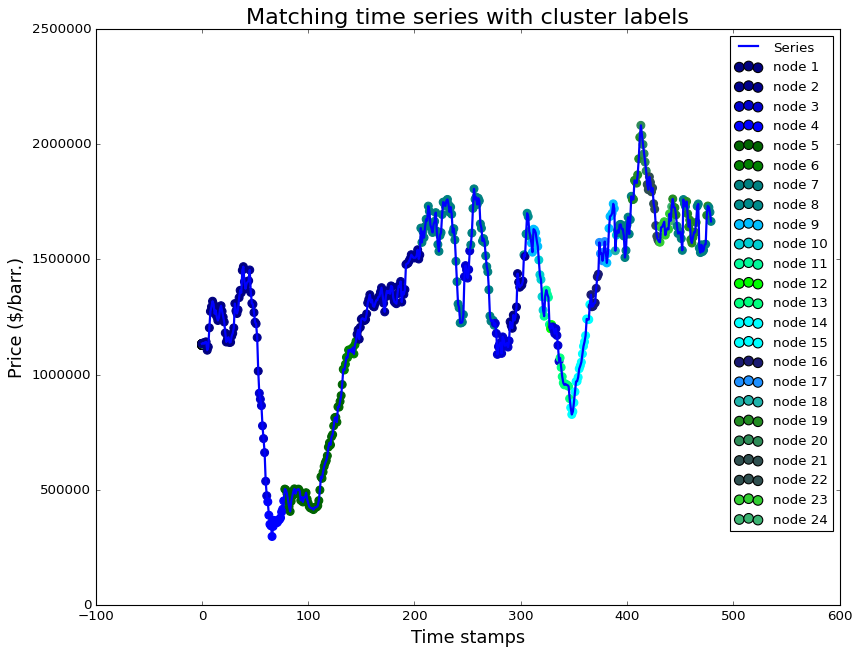

In [13]:
colors=list(matplotlib.colors.CSS4_COLORS.values())[::-1]
colors.sort()
plt.figure(1,figsize=(12,9), facecolor='w')
plt.title('Matching time series with cluster labels', size=20)
clss=[colors[i] for i in traject.cluster.values ]#-cltabula.cluster.values
for i in traject.cluster.drop_duplicates():
    plt.scatter(traject.step[0], traject['t-0'][0], c=colors[i],  s=75)
plt.scatter(traject.step, traject['t-0'], color=clss,  s=50)
plt.plot(traject['t-0'], lw=2)
plt.xlabel('Time stamps', size=16)
plt.ylabel('Price ($/barr.)', size=16)
plt.legend(['Series']+['node %i'%i for i in traject.cluster.drop_duplicates()], fontsize=12, loc='best',  bbox_to_anchor=(1, 1))
plt.show()

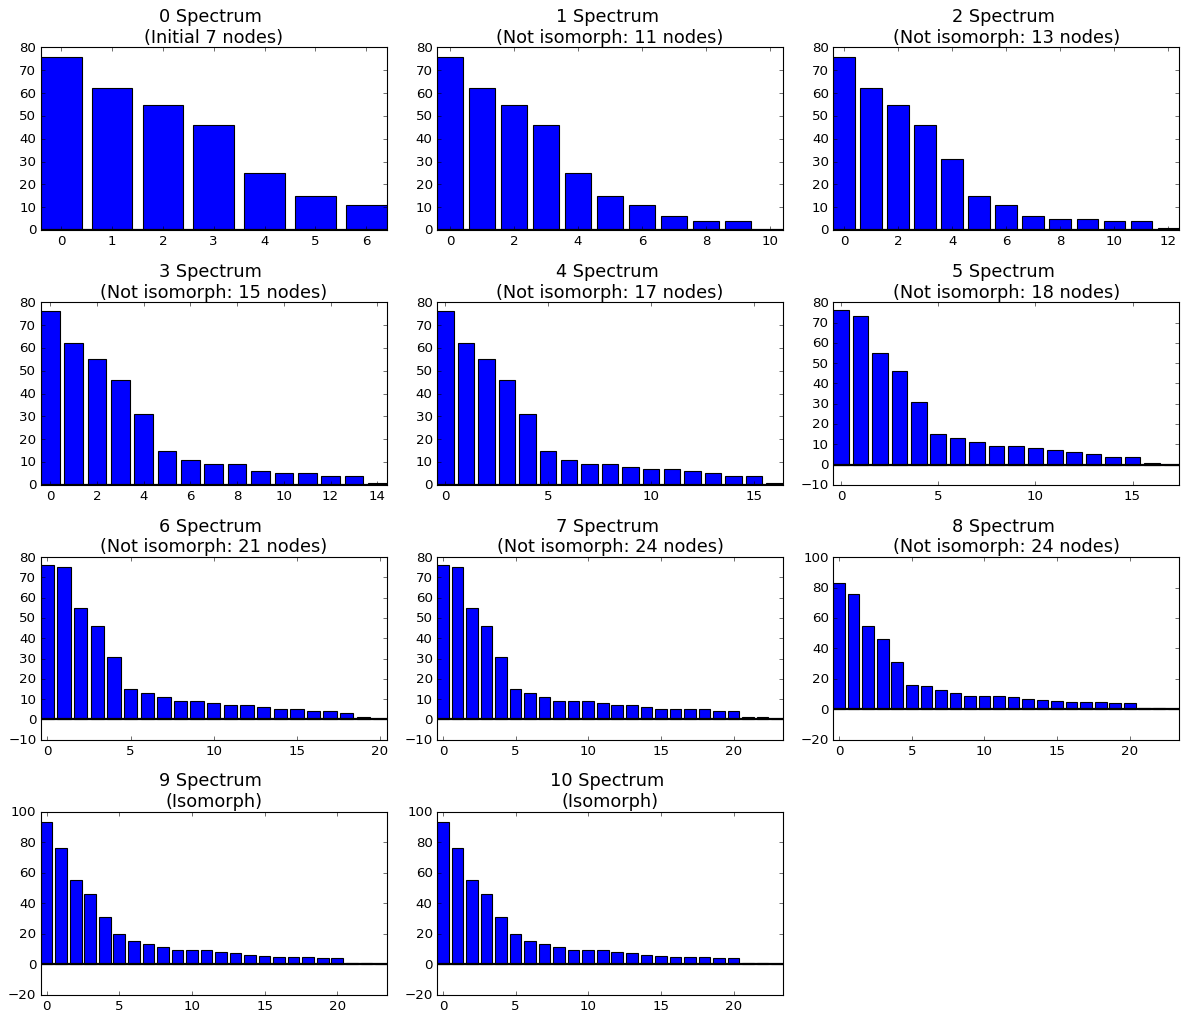

In [14]:
fig=plt.figure(figsize=(15, 35), facecolor='w')
matplotlib.style.use('fast')
for i, g in enumerate(gra):
    plt.subplot(len(gra),3,i+1)
    m = AdjMatr(g, paint=False)
    en, ev=np.linalg.eig(m)
    n=len(en)
    if i:
        isom ='Isomorph' if nx.is_isomorphic(gra[i-1], g) else 'Not isomorph: %i nodes'%g.number_of_nodes()
    else:
        isom ='Initial %i nodes'%g.number_of_nodes()
    plt.title("%d Spectrum \n(%s)"%(i, isom), size=16)
    plt.bar(np.arange(n), np.sort(en.real)[::-1], width=.8)
    plt.xlim(-.4, g.number_of_nodes()-.6 )
    plt.axhline(0, lw=2, c='black')
plt.tight_layout()
plt.show()

In [29]:
g=dict(G2.edges())
print(tabulate(zip(g.keys(), list(g.values())), headers=['edge', 'weight'], tablefmt="pretty", stralign=['left']))

+----------+----------------+
|     edge |         weight |
+----------+----------------+
| (1, 1)   | {'weight': 31} |
| (1, 2)   | {'weight': 1}  |
| (1, 6)   | {'weight': 1}  |
| (2, 2)   | {'weight': 1}  |
| (2, 3)   | {'weight': 1}  |
| (3, 3)   | {'weight': 1}  |
| (3, 4)   | {'weight': 1}  |
| (4, 5)   | {'weight': 1}  |
| (5, 5)   | {'weight': 1}  |
| (5, 6)   | {'weight': 1}  |
| (6, 6)   | {'weight': 27} |
| (6, 7)   | {'weight': 1}  |
| (6, 1)   | {'weight': 1}  |
| (7, 8)   | {'weight': 1}  |
| (8, 8)   | {'weight': 1}  |
| (8, 9)   | {'weight': 1}  |
| (9, 9)   | {'weight': 1}  |
| (9, 10)  | {'weight': 1}  |
| (10, 11) | {'weight': 1}  |
| (11, 11) | {'weight': 1}  |
| (11, 12) | {'weight': 1}  |
| (12, 12) | {'weight': 1}  |
| (12, 13) | {'weight': 1}  |
| (13, 13) | {'weight': 1}  |
| (13, 14) | {'weight': 1}  |
| (14, 14) | {'weight': 2}  |
| (14, 15) | {'weight': 1}  |
| (15, 15) | {'weight': 1}  |
| (15, 16) | {'weight': 1}  |
| (16, 16) | {'weight': 1}  |
| (16, 17)